# Flocking behavior

This notebook presents an agent-based model that simulates the flocking behavior of animals. It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package for models with a continuous space with two or three dimensions.

In [2]:
# Model design
import agentpy as ap
import numpy as np

# Visualization
import matplotlib.pyplot as plt 
import IPython

In [1]:
!pip install agentpy

## About the model

The boids model was invented by [Craig Reynolds](http://www.red3d.com/cwr/boids/), who describes it as follows:

> In 1986 I made a computer model of coordinated animal motion such as bird flocks and fish schools. It was based on three dimensional computational geometry of the sort normally used in computer animation or computer aided design. I called the generic simulated flocking creatures boids. The basic flocking model consists of three simple steering behaviors which describe how an individual boid maneuvers based on the positions and velocities its nearby flockmates:
> - Separation: steer to avoid crowding local flockmates
> - Alignment: steer towards the average heading of local flockmates
> - Cohesion: steer to move toward the average position of local flockmates 

The model presented here is a simplified implementation of this algorithm, following the [Boids Pseudocode](http://www.vergenet.net/~conrad/boids/pseudocode.html) written by Conrad Parker.

If you want to see a real-world example of flocking behavior, check out this fascinating video of Starling murmurations from National Geographic:

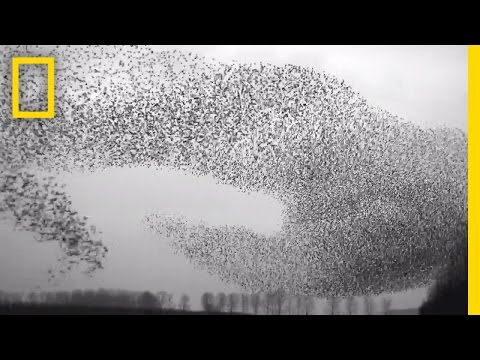

In [4]:
IPython.display.YouTubeVideo('V4f_1_r80RY', width=600, height=350)

## Model definition

The Boids model is based on two classes, one for the agents, and one for the overall model.
For more information about this structure, take a look at the [creating models](https://agentpy.readthedocs.io/en/latest/overview.html#creating-models).

Each agent starts with a random position and velocity, which are implemented as numpy [arrays](https://numpy.org/doc/stable/reference/generated/numpy.array.html).
The position is defined through the space environment,
which the agent can access via `Agent.position()` and `Agent.neighbors()`.

The methods `update_velocity()` and `update_position()` are separated so that all agents can
update their velocity before the actual movement takes place.
For more information about the algorithm in `update_velocity()`, 
check out the [Boids Pseudocode](http://www.vergenet.net/~conrad/boids/pseudocode.html).

In [3]:
def normalize(v):
    """ Normalize a vector to length 1. """
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

In [10]:
class Boid(ap.Agent):
    """ An agent with a position and velocity in a continuous space,
    who follows Craig Reynolds three rules of flocking behavior; 
    plus a fourth rule to avoid the edges of the simulation space. """
    
    def setup(self): 
        
        self.velocity = normalize(
            self.model.nprandom.random(self.p.ndim) - 0.5)
    
    def setup_pos(self, space):
        
        self.space = space
        self.neighbors = space.neighbors
        self.pos = space.positions[self]
    
    def update_velocity(self):
        
        pos = self.pos
        ndim = self.p.ndim
        
        # Rule 1 - Cohesion
        nbs = self.neighbors(self, distance=self.p.outer_radius)
        nbs_len = len(nbs)
        nbs_pos_array = np.array(nbs.pos)
        nbs_vec_array = np.array(nbs.velocity)
        if nbs_len > 0:
            center = np.sum(nbs_pos_array, 0) / nbs_len
            v1 = (center - pos) * self.p.cohesion_strength 
        else:
            v1 = np.zeros(ndim)
        
        # Rule 2 - Seperation
        v2 = np.zeros(ndim)
        for nb in self.neighbors(self, distance=self.p.inner_radius):
            v2 -= nb.pos - pos
        v2 *= self.p.seperation_strength
        
        # Rule 3 - Alignment
        if nbs_len > 0:
            average_v = np.sum(nbs_vec_array, 0) / nbs_len
            v3 = (average_v - self.velocity) * self.p.alignment_strength 
        else:
            v3 = np.zeros(ndim)
        
        # Rule 4 - Borders
        v4 = np.zeros(ndim)
        d = self.p.border_distance
        s = self.p.border_strength 
        for i in range(ndim):
            if pos[i] < d:
                v4[i] += s
            elif pos[i] > self.space.shape[i] - d:
                v4[i] -= s
        
        # Update velocity
        self.velocity += v1 + v2 + v3 + v4
        self.velocity = normalize(self.velocity)
    
    def update_position(self):
        
        self.space.move_by(self, self.velocity)   

NameError: name 'ap' is not defined

In [5]:
class BoidsModel(ap.Model):
    """ 
    An agent-based model of animals' flocking behavior,
    based on Craig Reynolds' Boids Model [1]
    and Conrad Parkers' Boids Pseudocode [2].
    
    [1] http://www.red3d.com/cwr/boids/
    [2] http://www.vergenet.net/~conrad/boids/pseudocode.html
    """
    
    def setup(self):
        """ Initializes the agents and network of the model. """
        
        self.space = ap.Space(self, shape=[self.p.size]*self.p.ndim)
        self.agents = ap.AgentList(self, self.p.population, Boid)
        self.space.add_agents(self.agents, random=True)
        self.agents.setup_pos(self.space)

    def step(self):   
        """ Defines the models' events per simulation step. """
        
        self.agents.update_velocity()  # Adjust direction
        self.agents.update_position()  # Move into new direction

## Visualization functions

Next, we define a plot function that can take our model and parameters as an input and creates an animated plot with `animate()`:

In [5]:
def animation_plot_single(m, ax):
    ndim = m.p.ndim
    ax.set_title(f"Boids Flocking Model {ndim}D t={m.t}")
    pos = m.space.positions.values()
    pos = np.array(list(pos)).T  # Transform
    ax.scatter(*pos, s=1, c='black')
    ax.set_xlim(0, m.p.size)
    ax.set_ylim(0, m.p.size)
    if ndim == 3:
        ax.set_zlim(0, m.p.size)
    ax.set_axis_off()
        
def animation_plot(m, p):
    projection = '3d' if p['ndim'] == 3 else None
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection=projection)
    animation = ap.animate(m(p), fig, ax, animation_plot_single)
    return IPython.display.HTML(animation.to_jshtml(fps=20)) 

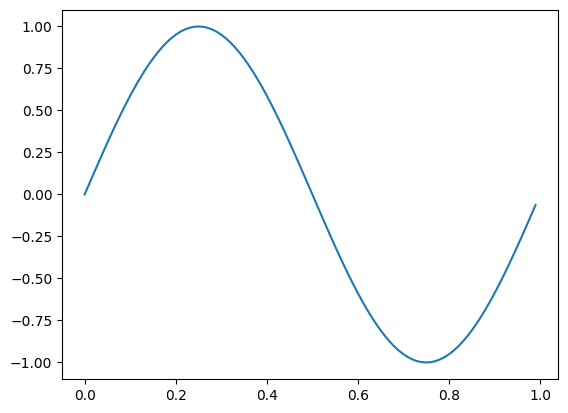

In [12]:
from matplotlib.backend_bases import MouseButton
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0.0, 1.0, 0.01)
s = np.sin(2 * np.pi * t)
fig, ax = plt.subplots()
ax.plot(t, s)


def on_move(event):
    if event.inaxes:
        print(f'data coords {event.xdata} {event.ydata},',
              f'pixel coords {event.x} {event.y}')


def on_click(event):
    if event.button is MouseButton.LEFT:
        print('disconnecting callback')
        plt.disconnect(binding_id)

binding_id = plt.connect('motion_notify_event', on_move)
plt.connect('button_press_event', on_click)

plt.show()

## Simulation (2D)

To run a simulation, we define a dictionary with our parameters:

In [7]:
parameters2D = {  
    'size': 75,
    'seed': 123,
    'steps': 200,
    'ndim': 2,
    'population': 5,
    'inner_radius': 3,
    'outer_radius': 15,
    'border_distance': 10,
    'cohesion_strength': 0.05,
    'seperation_strength': 0.5,
    'alignment_strength': 0.5,
    'border_strength': 0.5
} 

We can now display our first animation with two dimensions:

In [7]:
animation_plot(BoidsModel, parameters2D)

## Simulation (3D)

Finally, we can do the same with three dimensions, a larger number of agents, and a bit more space:

In [8]:
new_parameters = {  
    'ndim': 3,
    'population': 10,
} 

parameters3D = dict(parameters2D)
parameters3D.update(new_parameters)

animation_plot(BoidsModel, parameters3D)

NameError: name 'animation_plot' is not defined